In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [43]:
import numpy as np

class ProbabilisticCCA:
    def __init__(self, n_components=2, n_iters=100, reg=1e-5):
        self.k = n_components
        self.n_iters = n_iters
        self.reg = reg  # Regularization term

    def fit(self, X1, X2):
        # Check if the number of samples are the same
        if X1.shape[0] != X2.shape[0]:
            min_samples = min(X1.shape[0], X2.shape[0])
            X1 = X1[:min_samples]
            X2 = X2[:min_samples]
            print(f"Resized datasets to match number of samples: {min_samples}")
        
        self.K1 = X1.shape[1]  # Features in X1
        self.K2 = X2.shape[1]  # Features in X2
        self._init_params(X1, X2)
        
        for _ in range(self.n_iters):
            self._em_step()
        
        # Add regularization to ensure Psi is positive semi-definite
        self.Psi += self.reg * np.eye(self.Psi.shape[0])

    def _init_params(self, X1, X2):
        N = X1.shape[0]  # Number of samples
        self.K = self.K1 + self.K2  # Total number of features
        
        # Mean of concatenated data
        self.mu = np.concatenate([X1.mean(axis=0), X2.mean(axis=0)])

        # Covariance matrix
        S = np.cov(np.hstack([X1, X2]).T, bias=True)

        # Initialize weights W (adjusted for different K1 and K2)
        self.W = np.random.randn(self.K, self.k)
        
        # Initialize Psi as the residual variance
        self.Psi = np.diag(np.diag(S))

        print("Initial W matrix:", self.W)

    def _em_step(self):
        # Invert Psi
        Psi_inv = np.linalg.pinv(self.Psi)
        
        # Adjusted W multiplication
        print("W shape:", self.W.shape)
        print("Psi_inv shape:", Psi_inv.shape)
        
        # Ensure correct matrix multiplication order
        M = np.linalg.pinv(np.eye(self.k) + 0.01 * self.W.T @ Psi_inv @ self.W)

        
        # Update W using the posterior covariance
        self.W = Psi_inv @ self.W @ M
        print("Updated W matrix:", self.W)

        # Print values of Z (latent variable)
        Z = np.random.randn(self.W.shape[0], self.k)
        print("Latent variable Z:", Z[:5])

        # Update Psi to maintain positive semi-definiteness
        self.Psi = np.diag(np.maximum(np.diag(self.Psi), self.reg))


    def sample(self, n_samples=100):
        # Sample latent variables
        Z = np.random.randn(n_samples, self.k)
        print("Latent variable Z:", Z[:5])  # Print first few Z values to check if they are different
        
        # Generate new observations
        X = Z @ self.W.T + self.mu
        X = Z @ self.W.T + self.mu + np.random.normal(0, 0.1, X.shape)

        
        # Split the sampled X into X1 and X2
        X1_sampled = X[:, :self.K1]
        X2_sampled = X[:, self.K1:]

        return X1_sampled, X2_sampled


In [44]:
# Set dimensions
K1 = 500  # Number of observations for Group 1
K2 = 600  # Number of observations for Group 2
T = 250   # Number of time points
t = np.linspace(0, 2, T)  # Time intervals

# Latent dimensions
d_s = 1   # Shared latent dimension
d_1 = 2   # Independent latent dimension for group 1
d_2 = 3   # Independent latent dimension for group 2

# Hyperparameters
rho = 1.0  # Scale for GP kernel
l = 2.0    # Length scale for GP kernel
nu = 0.1   # Noise variance for observations

# Kernel function
def rbf_kernel(t1, t2, rho=1.0, l=2.0):
    """RBF (Gaussian) kernel for GP"""
    return rho * np.exp(-0.5 * ((t1[:, np.newaxis] - t2[np.newaxis, :]) / l)**2)

def generate_gp_trajectories(t, n_trajectories, kernel_func, nu=0.1):
    """Generate GP trajectories for latent factors"""
    K_tt = kernel_func(t, t)
    L = np.linalg.cholesky(K_tt + nu * np.eye(len(t)))
    trajectories = np.zeros((n_trajectories, len(t)))
    for k in range(n_trajectories):
        z = np.random.randn(len(t))
        trajectories[k] = L @ z
    return trajectories

# Generate latent trajectories
Z_shared = generate_gp_trajectories(t, d_s, rbf_kernel).T  # Shape will be (T, d_s)
Z_1 = generate_gp_trajectories(t, d_1, rbf_kernel).T      # Shape will be (T, d_1)
Z_2 = generate_gp_trajectories(t, d_2, rbf_kernel).T      # Shape will be (T, d_2)

# Generate loading matrices
A_s1 = np.random.randn(K1, d_s)  # Loading matrix for shared component, group 1
A_s2 = np.random.randn(K2, d_s)  # Loading matrix for shared component, group 2
A_1 = np.random.randn(K1, d_1)   # Loading matrix for independent component, group 1
A_2 = np.random.randn(K2, d_2)   # Loading matrix for independent component, group 2

# Generate observations
X1 = np.zeros((K1, T))
X2 = np.zeros((K2, T))

# Generate observations for Group 1
for i in range(K1):
    shared_contrib = A_s1[i:i+1, :] @ Z_shared.T  # (1,d_s) @ (d_s,T) = (1,T)
    indep_contrib = A_1[i:i+1, :] @ Z_1.T         # (1,d_1) @ (d_1,T) = (1,T)
    X1[i] = (shared_contrib + indep_contrib).flatten()

# Generate observations for Group 2
for i in range(K2):
    shared_contrib = A_s2[i:i+1, :] @ Z_shared.T  # (1,d_s) @ (d_s,T) = (1,T)
    indep_contrib = A_2[i:i+1, :] @ Z_2.T         # (1,d_2) @ (d_2,T) = (1,T)
    X2[i] = (shared_contrib + indep_contrib).flatten()

# Add observation noise
X1 += np.random.normal(0, np.sqrt(nu), X1.shape)
X2 += np.random.normal(0, np.sqrt(nu), X2.shape)

# Print shapes to verify
print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)

X1 shape: (500, 250)
X2 shape: (600, 250)


Resized datasets to match number of samples: 500
Initial W matrix: [[ 1.96938116e-03  3.26540360e-01]
 [-3.47219962e-01 -1.02331854e-01]
 [-2.29606305e-01  1.84631820e+00]
 [ 1.56496927e+00 -3.24268554e-01]
 [ 1.52112719e+00  2.04417888e+00]
 [-3.27790602e-01 -1.02753999e+00]
 [ 7.31530156e-01 -3.21107612e-01]
 [ 8.19507996e-01  3.01702288e-02]
 [ 3.52377965e-01 -3.07044085e-01]
 [-1.67651943e-01  2.21777068e+00]
 [ 1.59601706e+00  3.46255236e-01]
 [ 2.90600393e-01  1.21166518e-02]
 [ 8.87700228e-01  1.62008576e+00]
 [-6.39568721e-01 -1.14690926e+00]
 [-2.16910775e+00 -9.11809290e-01]
 [ 1.13463943e+00  1.75335710e+00]
 [ 1.67952265e+00  1.15403860e+00]
 [ 4.62615298e-01  2.24080209e-01]
 [ 3.01067482e-01  9.36828483e-01]
 [ 1.23907532e+00 -9.95783293e-01]
 [-6.57405766e-01  4.82827017e-02]
 [-5.96167185e-01 -1.45437119e+00]
 [-1.82664451e+00 -3.62920543e-01]
 [ 1.47584678e+00 -2.74968769e-01]
 [ 1.93195815e+00  7.58060838e-01]
 [-5.39881129e-01 -6.01394986e-02]
 [ 2.80629200e+00 -1.27

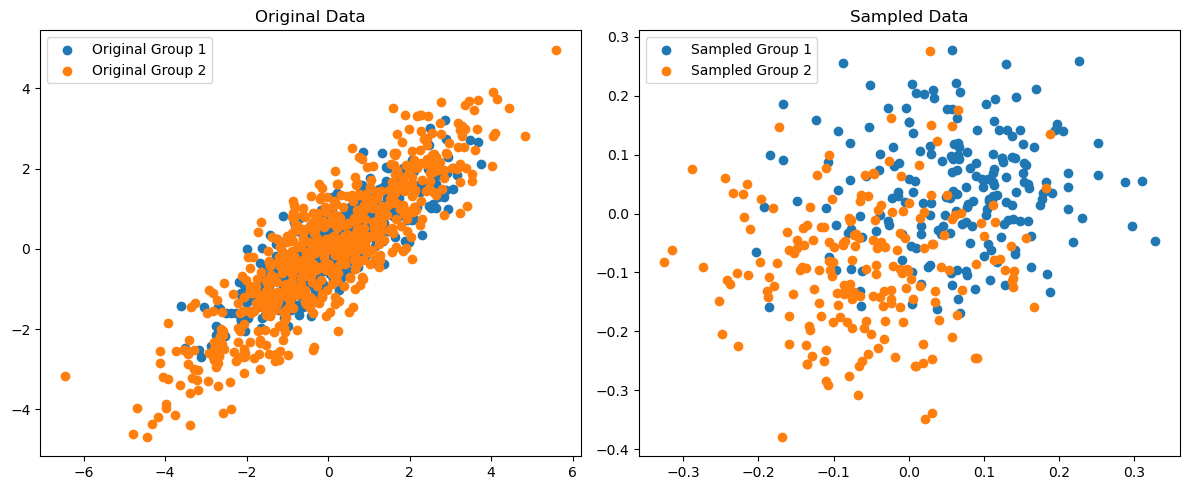

In [45]:
pcca = ProbabilisticCCA(n_components=2, n_iters=100)
pcca.fit(X1, X2)
X1_, X2_ = pcca.sample(200)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(X1[:, 0], X1[:, 1], label='Original Group 1')
ax1.scatter(X2[:, 0], X2[:, 1], label='Original Group 2')
ax1.set_title('Original Data')
ax1.legend()

ax2.scatter(X1_[:, 0], X1_[:, 1], label='Sampled Group 1')
ax2.scatter(X2_[:, 0], X2_[:, 1], label='Sampled Group 2')
ax2.set_title('Sampled Data')
ax2.legend()

plt.tight_layout()
plt.show()

In [36]:
#try using vstack instead of hstack so the dimensions line up properly
#alternatively, input to the function the tranposes of X1 and X2
# PIPELINE: IBL data --> vGPFA --> pCCA model


#next: compare how well our model does against some other model
#can also compare about some really simple models, like PCA
#take note of what i needed to change about greg's model to fit it for out project